In [1]:
#============================================================================
# PARKINSON'S DISEASE DETECTION FROM GAIT DATA
# ML Pipeline: Logistic Regression → Random Forest
# Dataset: PhysioNet Gait in Parkinson's Disease
# ============================================================================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
#Loading the data files
# ============================================================================

import glob
import re
from tqdm import tqdm  # For progress bar (install if needed: pip install tqdm)

DATA_DIR = Path("../data/archive")

In [6]:
#mergin the dataset and making it ready for analysis
# ============================================================================

column_names = ['Time'] + \
               [f'L{i}' for i in range(1, 9)] + \
               [f'R{i}' for i in range(1, 9)] + \
               ['Total_Left', 'Total_Right']

def extract_metadata(filename):
    """
    Extract study, subject type (Co/Pt), subject ID, and walk number from filename
    Example: GaCo01_02.txt -> study='Ga', type='Co', subject=1, walk=2
    """
    # Remove .txt extension
    name = Path(filename).stem
    
    # Parse filename using regex
    match = re.match(r'([A-Za-z]+)(Co|Pt)(\d+)_(\d+)', name)
    
    if match:
        study = match.group(1)  # Ga, Ju, or Si
        subject_type = match.group(2)  # Co or Pt
        subject_id = int(match.group(3))
        walk_number = int(match.group(4))
        
        # Create label: 0 = Control, 1 = Parkinson's
        label = 0 if subject_type == 'Co' else 1
        
        # Create unique subject identifier
        subject_full_id = f"{study}{subject_type}{subject_id:02d}"
        
        return {
            'study': study,
            'subject_type': subject_type,
            'subject_id': subject_id,
            'subject_full_id': subject_full_id,
            'walk_number': walk_number,
            'label': label,
            'label_name': 'Control' if label == 0 else 'Parkinsons'
        }
    else:
        return None

# Find all .txt data files (exclude format.txt, README, etc.)
data_files = list(DATA_DIR.glob("*.txt"))
data_files = [f for f in data_files if 'format' not in f.name.lower() 
              and 'readme' not in f.name.lower()
              and 'description' not in f.name.lower()]

print(f"\n✓ Found {len(data_files)} data files")

# Load and merge all files
all_data = []

print("\nLoading files...")
for file_path in tqdm(data_files):
    # Extract metadata from filename
    metadata = extract_metadata(file_path.name)
    
    if metadata is None:
        print(f"⚠️  Skipping file (couldn't parse): {file_path.name}")
        continue
    
    try:
        # Load the data file
        df = pd.read_csv(file_path, sep='\s+', header=None, names=column_names)
        
        # Add metadata columns
        for key, value in metadata.items():
            df[key] = value
        
        # Add filename for reference
        df['filename'] = file_path.name
        
        all_data.append(df)
        
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")

# Combine all data
print("\nMerging all files into one DataFrame...")
df_combined = pd.concat(all_data, ignore_index=True)

print("\n" + "=" * 60)
print("DATA LOADING COMPLETE")
print("=" * 60)
print(f"Total records: {len(df_combined):,}")
print(f"Total subjects: {df_combined['subject_full_id'].nunique()}")
print(f"Total walks/trials: {len(data_files)}")
print(f"\nColumns: {len(df_combined.columns)}")
print(f"Memory usage: {df_combined.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
class_dist = df_combined.groupby('label_name')['subject_full_id'].nunique()
print(class_dist)
print(f"\nTotal unique subjects:")
print(f"  - Controls: {class_dist.get('Control', 0)}")
print(f"  - Parkinson's: {class_dist.get('Parkinsons', 0)}")

# Show sample of the data
print("\n" + "=" * 60)
print("SAMPLE DATA")
print("=" * 60)
print(df_combined.head(10))

# Show data types
print("\n" + "=" * 60)
print("DATA INFO")
print("=" * 60)
print(df_combined.info())


✓ Found 308 data files

Loading files...


 51%|█████     | 157/308 [00:01<00:01, 96.74it/s]

⚠️  Skipping file (couldn't parse): demographics.txt


 95%|█████████▌| 294/308 [00:03<00:00, 90.97it/s]

⚠️  Skipping file (couldn't parse): SHA256SUMS.txt


100%|██████████| 308/308 [00:03<00:00, 84.84it/s]



Merging all files into one DataFrame...

DATA LOADING COMPLETE
Total records: 3,317,550
Total subjects: 165
Total walks/trials: 308

Columns: 27
Memory usage: 1433.50 MB

CLASS DISTRIBUTION
label_name
Control       72
Parkinsons    93
Name: subject_full_id, dtype: int64

Total unique subjects:
  - Controls: 72
  - Parkinson's: 93

SAMPLE DATA
   Time      L1      L2      L3     L4     L5     L6     L7    L8    R1  ...  \
0  0.00  111.65  437.91  319.00  62.81  13.53  84.81  72.93  12.1  0.00  ...   
1  0.01  111.65  437.91  319.00  62.81  13.53  84.81  72.93  12.1  0.00  ...   
2  0.02  110.22  436.15  320.65  62.81  13.53  86.35  55.77  12.1  0.00  ...   
3  0.03  110.22  434.50  319.00  61.38  13.53  88.00  54.34  12.1  0.00  ...   
4  0.04  108.79  432.74  319.00  62.81  13.53  88.00  57.20  12.1  0.00  ...   
5  0.05  108.79  429.22  319.00  62.81  13.53  89.54  57.20  12.1  0.00  ...   
6  0.06  108.79  427.57  319.00  61.38  13.53  89.54  57.20  12.1  0.00  ...   
7  0.07  107.4

In [7]:
# Cell 5: Save Combined Dataset to CSV
# ============================================================================

# Create output directory if it doesn't exist
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
output_file = output_dir / "gait_data_combined.csv"
df_combined.to_csv(output_file, index=False)

print("=" * 60)
print("DATASET SAVED")
print("=" * 60)
print(f"✓ Saved to: {output_file}")
print(f"✓ File size: {output_file.stat().st_size / 1024**2:.2f} MB")
print(f"\nYou can now reload this file quickly with:")
print(f"df = pd.read_csv('{output_file}')")

DATASET SAVED
✓ Saved to: ../data/processed/gait_data_combined.csv
✓ File size: 469.45 MB

You can now reload this file quickly with:
df = pd.read_csv('../data/processed/gait_data_combined.csv')


In [8]:
df = pd.read_csv('../data/processed/gait_data_combined.csv')

In [9]:
df.head()

,Time,L1,L2,L3,L4,L5,L6,L7,L8,R1,...,Total_Left,Total_Right,study,subject_type,subject_id,subject_full_id,walk_number,label,label_name,filename
0,0.00,111.65,437.91,319.00,62.81,13.53,84.81,72.93,12.1,0.0,...,1114.74,9.79,Ju,Co,23,JuCo23,1,0,Control,JuCo23_01.txt
1,0.01,111.65,437.91,319.00,62.81,13.53,84.81,72.93,12.1,0.0,...,1114.74,9.79,Ju,Co,23,JuCo23,1,0,Control,JuCo23_01.txt
2,0.02,110.22,436.15,320.65,62.81,13.53,86.35,55.77,12.1,0.0,...,1097.58,9.79,Ju,Co,23,JuCo23,1,0,Control,JuCo23_01.txt
3,0.03,110.22,434.50,319.00,61.38,13.53,88.00,54.34,12.1,0.0,...,1093.07,9.79,Ju,Co,23,JuCo23,1,0,Control,JuCo23_01.txt
4,0.04,108.79,432.74,319.00,62.81,13.53,88.00,57.20,12.1,0.0,...,1094.17,9.79,Ju,Co,23,JuCo23,1,0,Control,JuCo23_01.txt


In [10]:
# Quick data verification
print("Data Shape:", df_combined.shape)
print("\nFirst subject's first few rows:")
print(df_combined.head(3))
print("\nColumn names:")
print(df_combined.columns.tolist())
print("\nData types look correct?")
print(df_combined.dtypes)

Data Shape: (3317550, 27)

First subject's first few rows:
   Time      L1      L2      L3     L4     L5     L6     L7    L8   R1  ...  \
0  0.00  111.65  437.91  319.00  62.81  13.53  84.81  72.93  12.1  0.0  ...   
1  0.01  111.65  437.91  319.00  62.81  13.53  84.81  72.93  12.1  0.0  ...   
2  0.02  110.22  436.15  320.65  62.81  13.53  86.35  55.77  12.1  0.0  ...   

   Total_Left  Total_Right  study  subject_type  subject_id  subject_full_id  \
0     1114.74         9.79     Ju            Co          23           JuCo23   
1     1114.74         9.79     Ju            Co          23           JuCo23   
2     1097.58         9.79     Ju            Co          23           JuCo23   

   walk_number  label  label_name       filename  
0            1      0     Control  JuCo23_01.txt  
1            1      0     Control  JuCo23_01.txt  
2            1      0     Control  JuCo23_01.txt  

[3 rows x 27 columns]

Column names:
['Time', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'R1'

Comparing:
  Control: JuCo23
  Parkinson's: JuPt10


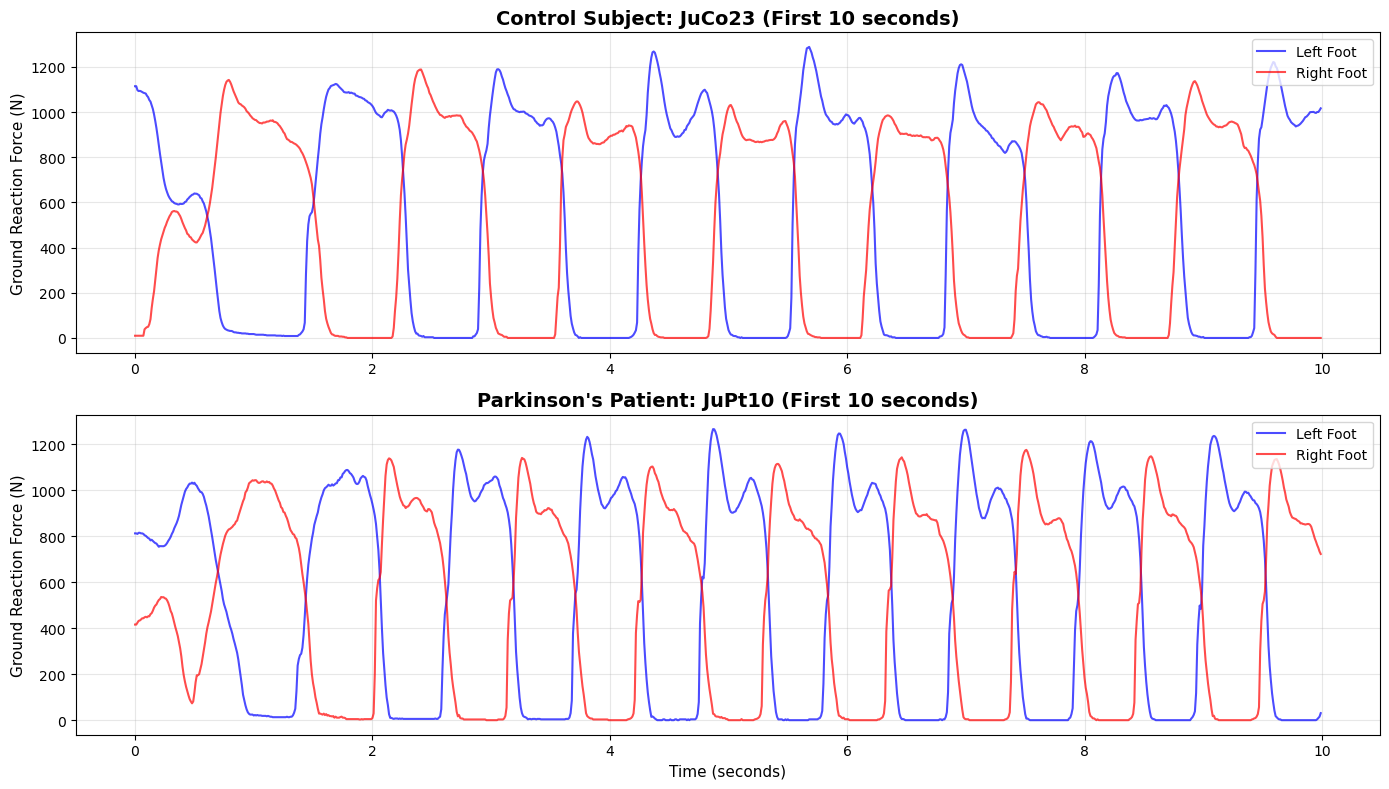


✓ Visualization saved to: ../results/figures/gait_comparison.png


In [ ]:
# Create directories and visualize
# ============================================================================

# Create directories if they don't exist
Path("../results/figures").mkdir(parents=True, exist_ok=True)

# Pick one Control and one Parkinson's subject for comparison
control_subject = df_combined[df_combined['label'] == 0]['subject_full_id'].iloc[0]
parkinsons_subject = df_combined[df_combined['label'] == 1]['subject_full_id'].iloc[0]

print(f"Comparing:")
print(f"  Control: {control_subject}")
print(f"  Parkinson's: {parkinsons_subject}")

# Get one walk from each
control_walk = df_combined[
    (df_combined['subject_full_id'] == control_subject) & 
    (df_combined['walk_number'] == 1)
].head(1000)  # First 10 seconds (1000 samples at 100Hz)

parkinsons_walk = df_combined[
    (df_combined['subject_full_id'] == parkinsons_subject) & 
    (df_combined['walk_number'] == 1)
].head(1000)  # First 10 seconds

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot Control subject
axes[0].plot(control_walk['Time'], control_walk['Total_Left'], 
             label='Left Foot', color='blue', linewidth=1.5, alpha=0.7)
axes[0].plot(control_walk['Time'], control_walk['Total_Right'], 
             label='Right Foot', color='red', linewidth=1.5, alpha=0.7)
axes[0].set_title(f'Control Subject: {control_subject} (First 10 seconds)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ground Reaction Force (N)', fontsize=11)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot Parkinson's patient
axes[1].plot(parkinsons_walk['Time'], parkinsons_walk['Total_Left'], 
             label='Left Foot', color='blue', linewidth=1.5, alpha=0.7)
axes[1].plot(parkinsons_walk['Time'], parkinsons_walk['Total_Right'], 
             label='Right Foot', color='red', linewidth=1.5, alpha=0.7)
axes[1].set_title(f'Parkinson\'s Patient: {parkinsons_subject} (First 10 seconds)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (seconds)', fontsize=11)
axes[1].set_ylabel('Ground Reaction Force (N)', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/gait_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: ../results/figures/gait_comparison.png")

In [13]:
#about the graph above

#1. Right foot hits ground → RED line goes UP (force increases)
#2. Left foot is in air → BLUE line is at ZERO
#3. Right foot pushes off → RED line goes DOWN
#4. Left foot hits ground → BLUE line goes UP
#5. Right foot is in air → RED line is at ZERO
#6. REPEAT

In [14]:
# Data Quality Check
# ============================================================================

print("=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)

# 1. Missing values
print("\n1. MISSING VALUES:")
missing = df_combined.isnull().sum()
missing_total = missing.sum()
if missing_total == 0:
    print("   ✓ No missing values!")
else:
    print(f"   ⚠️ Found {missing_total} missing values:")
    print(missing[missing > 0])

# 2. Negative forces (should not exist - force is always positive or zero)
print("\n2. NEGATIVE FORCES CHECK:")
force_cols = [f'L{i}' for i in range(1, 9)] + [f'R{i}' for i in range(1, 9)] + ['Total_Left', 'Total_Right']
negative_count = (df_combined[force_cols] < 0).sum().sum()
if negative_count == 0:
    print("   ✓ No negative force values!")
else:
    print(f"   ⚠️ Found {negative_count} negative values - needs cleaning")

# 3. Outliers (extremely high forces - likely sensor errors)
print("\n3. OUTLIER CHECK:")
max_force = df_combined[force_cols].max().max()
print(f"   Maximum force value: {max_force:.2f} N")
print(f"   (Normal range: 0-2000 N for adult walking)")
if max_force > 3000:
    print(f"   ⚠️ Possible outliers detected")
else:
    print(f"   ✓ Values within reasonable range")

# 4. Zero-only records (subject not walking)
print("\n4. ZERO-FORCE RECORDS:")
zero_records = ((df_combined['Total_Left'] == 0) & (df_combined['Total_Right'] == 0)).sum()
zero_pct = (zero_records / len(df_combined)) * 100
print(f"   Records with both feet at zero: {zero_records:,} ({zero_pct:.2f}%)")
print(f"   (Some zeros are normal - feet in air during walking)")

# 5. Data continuity (check for time gaps)
print("\n5. TIME CONTINUITY:")
sample_subject = df_combined[df_combined['subject_full_id'] == 'JuCo23']
sample_walk = sample_subject[sample_subject['walk_number'] == 1]['Time']
time_diffs = sample_walk.diff().dropna()
expected_diff = 0.01  # 100 Hz = 0.01 second intervals
irregular_intervals = (abs(time_diffs - expected_diff) > 0.001).sum()
print(f"   Checked one sample walk: {len(time_diffs)} intervals")
print(f"   Irregular time intervals: {irregular_intervals}")
if irregular_intervals == 0:
    print(f"   ✓ Time sampling is consistent (100 Hz)")
else:
    print(f"   ⚠️ Some irregular time intervals detected")

print("\n" + "=" * 60)
print("RECOMMENDATION:")
print("=" * 60)

DATA QUALITY CHECK

1. MISSING VALUES:
   ✓ No missing values!

2. NEGATIVE FORCES CHECK:
   ✓ No negative force values!

3. OUTLIER CHECK:
   Maximum force value: 1911.03 N
   (Normal range: 0-2000 N for adult walking)
   ✓ Values within reasonable range

4. ZERO-FORCE RECORDS:
   Records with both feet at zero: 0 (0.00%)
   (Some zeros are normal - feet in air during walking)

5. TIME CONTINUITY:
   Checked one sample walk: 9873 intervals
   Irregular time intervals: 0
   ✓ Time sampling is consistent (100 Hz)

RECOMMENDATION:


TESTING HEEL STRIKE DETECTION

Test subject: JuCo23
Walk duration: 98.72 seconds
Total samples: 9874

Detected heel strikes:
  Left foot: 74 strikes
  Right foot: 74 strikes
  Total steps: 148


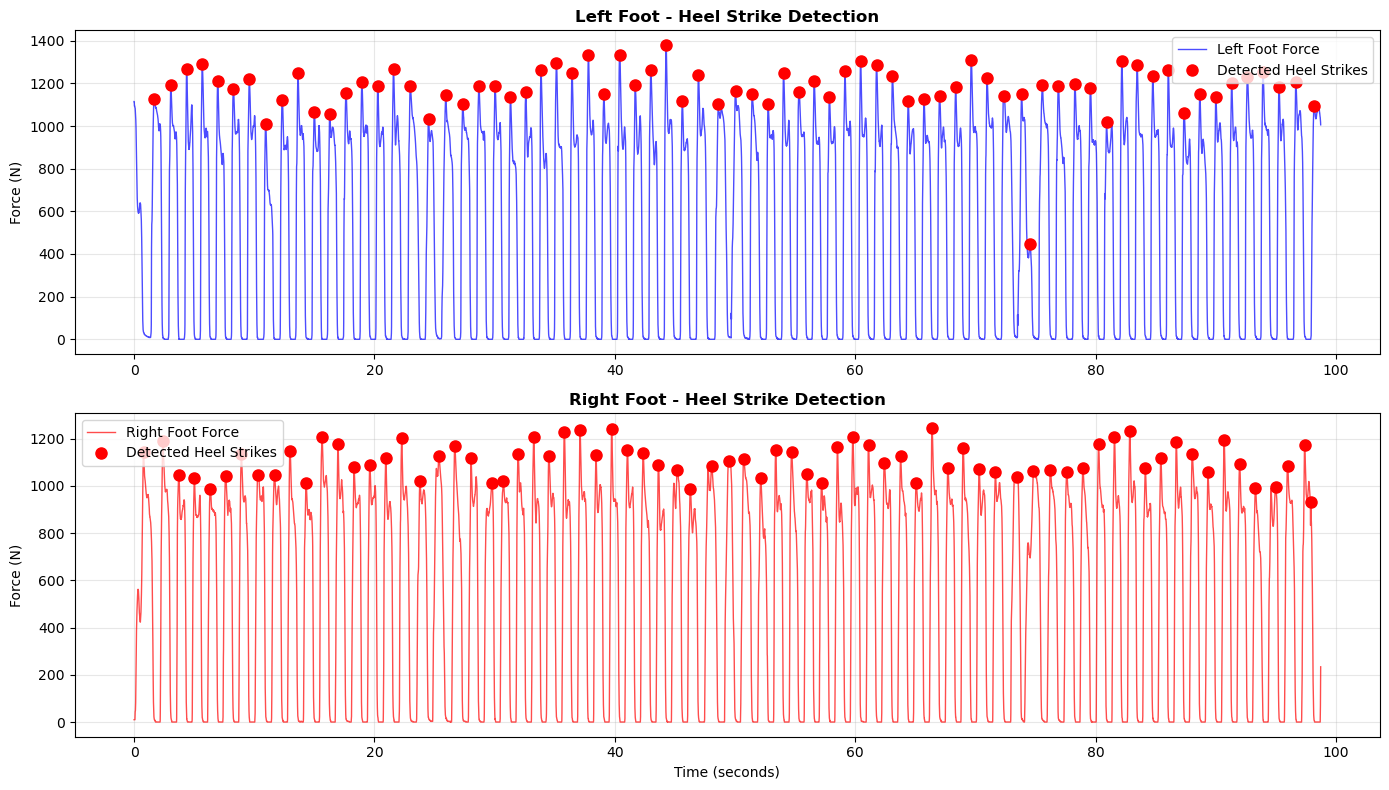


✓ Visualization saved!


In [15]:
# Cell 9: Gait Event Detection - Heel Strike Detection
# ============================================================================

from scipy.signal import find_peaks

def detect_heel_strikes(force_signal, min_distance=50, height=100):
    """
    Detect heel strikes (peaks) in ground reaction force signal
    
    Parameters:
    - force_signal: Total force from one foot (Total_Left or Total_Right)
    - min_distance: Minimum samples between peaks (50 = 0.5s at 100Hz)
    - height: Minimum force threshold to be considered a heel strike
    
    Returns:
    - indices: Array of peak locations (heel strike times)
    """
    peaks, properties = find_peaks(force_signal, 
                                   distance=min_distance, 
                                   height=height,
                                   prominence=50)
    return peaks

# Test on one subject
print("=" * 60)
print("TESTING HEEL STRIKE DETECTION")
print("=" * 60)

# Get one walk from a subject
test_subject = 'JuCo23'
test_walk = df_combined[
    (df_combined['subject_full_id'] == test_subject) & 
    (df_combined['walk_number'] == 1)
].copy()

print(f"\nTest subject: {test_subject}")
print(f"Walk duration: {test_walk['Time'].max():.2f} seconds")
print(f"Total samples: {len(test_walk)}")

# Detect heel strikes for left and right foot
left_heel_strikes = detect_heel_strikes(test_walk['Total_Left'].values)
right_heel_strikes = detect_heel_strikes(test_walk['Total_Right'].values)

print(f"\nDetected heel strikes:")
print(f"  Left foot: {len(left_heel_strikes)} strikes")
print(f"  Right foot: {len(right_heel_strikes)} strikes")
print(f"  Total steps: {len(left_heel_strikes) + len(right_heel_strikes)}")

# Visualize detection
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot left foot
axes[0].plot(test_walk['Time'].values, test_walk['Total_Left'].values, 
             'b-', linewidth=1, alpha=0.7, label='Left Foot Force')
axes[0].plot(test_walk['Time'].values[left_heel_strikes], 
             test_walk['Total_Left'].values[left_heel_strikes], 
             'ro', markersize=8, label='Detected Heel Strikes')
axes[0].set_title('Left Foot - Heel Strike Detection', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Force (N)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot right foot
axes[1].plot(test_walk['Time'].values, test_walk['Total_Right'].values, 
             'r-', linewidth=1, alpha=0.7, label='Right Foot Force')
axes[1].plot(test_walk['Time'].values[right_heel_strikes], 
             test_walk['Total_Right'].values[right_heel_strikes], 
             'ro', markersize=8, label='Detected Heel Strikes')
axes[1].set_title('Right Foot - Heel Strike Detection', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Force (N)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/heel_strike_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved!")

In [16]:
# Cell 10: Extract Temporal Features from One Walk
# ============================================================================

def extract_temporal_features_single_walk(walk_data):
    """
    Extract 10 temporal features from a single walking trial
    
    Parameters:
    - walk_data: DataFrame containing one walk (filtered by subject_id and walk_number)
    
    Returns:
    - Dictionary with 10 temporal features
    """
    
    # Get force signals
    left_force = walk_data['Total_Left'].values
    right_force = walk_data['Total_Right'].values
    time = walk_data['Time'].values
    sampling_rate = 100  # Hz
    
    # Detect heel strikes
    left_hs = detect_heel_strikes(left_force)
    right_hs = detect_heel_strikes(right_force)
    
    # Initialize features dictionary
    features = {}
    
    # ============================================================
    # FEATURE 1 & 2: Stride Time (Left and Right)
    # ============================================================
    # Stride = time from one heel strike to next heel strike of SAME foot
    
    if len(left_hs) >= 2:
        left_stride_times = np.diff(time[left_hs])  # Time differences between consecutive left heel strikes
        features['stride_time_left_mean'] = np.mean(left_stride_times)
    else:
        features['stride_time_left_mean'] = np.nan
    
    if len(right_hs) >= 2:
        right_stride_times = np.diff(time[right_hs])
        features['stride_time_right_mean'] = np.mean(right_stride_times)
    else:
        features['stride_time_right_mean'] = np.nan
    
    # ============================================================
    # FEATURE 3: Step Time
    # ============================================================
    # Step = time between alternating feet (left to right or right to left)
    
    # Combine and sort all heel strikes
    all_hs = np.sort(np.concatenate([left_hs, right_hs]))
    
    if len(all_hs) >= 2:
        step_times = np.diff(time[all_hs])
        features['step_time_mean'] = np.mean(step_times)
    else:
        features['step_time_mean'] = np.nan
    
    # ============================================================
    # FEATURE 4: Cadence (steps per minute)
    # ============================================================
    
    if len(all_hs) >= 2:
        total_duration = time[all_hs[-1]] - time[all_hs[0]]  # Duration from first to last heel strike
        num_steps = len(all_hs) - 1
        steps_per_second = num_steps / total_duration
        features['cadence'] = steps_per_second * 60  # Convert to steps per minute
    else:
        features['cadence'] = np.nan
    
    # ============================================================
    # FEATURE 5: Stance Time Ratio
    # ============================================================
    # Stance = foot on ground (force > threshold)
    
    stance_threshold = 50  # Newtons
    left_stance_samples = np.sum(left_force > stance_threshold)
    right_stance_samples = np.sum(right_force > stance_threshold)
    total_samples = len(walk_data)
    
    # Average stance ratio for both feet
    features['stance_time_ratio'] = ((left_stance_samples + right_stance_samples) / (2 * total_samples)) * 100
    
    # ============================================================
    # FEATURE 6: Swing Time Ratio
    # ============================================================
    # Swing = 100% - Stance%
    
    features['swing_time_ratio'] = 100 - features['stance_time_ratio']
    
    # ============================================================
    # FEATURE 7 & 8: Stride Time CV (Coefficient of Variation) ⭐⭐⭐
    # ============================================================
    # CV = (std / mean) * 100
    # This is THE most important feature for Parkinson's detection!
    
    if len(left_hs) >= 3:  # Need at least 3 strikes for meaningful CV
        left_stride_times = np.diff(time[left_hs])
        features['stride_time_cv_left'] = (np.std(left_stride_times) / np.mean(left_stride_times)) * 100
    else:
        features['stride_time_cv_left'] = np.nan
    
    if len(right_hs) >= 3:
        right_stride_times = np.diff(time[right_hs])
        features['stride_time_cv_right'] = (np.std(right_stride_times) / np.mean(right_stride_times)) * 100
    else:
        features['stride_time_cv_right'] = np.nan
    
    # ============================================================
    # FEATURE 9: Step Time CV
    # ============================================================
    
    if len(all_hs) >= 4:
        step_times = np.diff(time[all_hs])
        features['step_time_cv'] = (np.std(step_times) / np.mean(step_times)) * 100
    else:
        features['step_time_cv'] = np.nan
    
    # ============================================================
    # FEATURE 10: Double Support Time ⭐⭐⭐
    # ============================================================
    # Time when BOTH feet are on ground simultaneously
    
    double_support_samples = np.sum((left_force > stance_threshold) & (right_force > stance_threshold))
    features['double_support_time'] = (double_support_samples / total_samples) * 100
    
    return features


# Test on one walk
print("=" * 60)
print("EXTRACTING TEMPORAL FEATURES - TEST")
print("=" * 60)

test_walk = df_combined[
    (df_combined['subject_full_id'] == 'JuCo23') & 
    (df_combined['walk_number'] == 1)
].copy()

features_test = extract_temporal_features_single_walk(test_walk)

print(f"\nExtracted features for {test_walk['subject_full_id'].iloc[0]} - Walk {test_walk['walk_number'].iloc[0]}:")
print(f"Label: {test_walk['label_name'].iloc[0]}\n")

for feature_name, feature_value in features_test.items():
    print(f"  {feature_name:30s}: {feature_value:8.3f}")

print("\n" + "=" * 60)
print("✓ Feature extraction working!")
print("=" * 60)

EXTRACTING TEMPORAL FEATURES - TEST

Extracted features for JuCo23 - Walk 1:
Label: Control

  stride_time_left_mean         :    1.322
  stride_time_right_mean        :    1.330
  step_time_mean                :    0.663
  cadence                       :   90.551
  stance_time_ratio             :   62.376
  swing_time_ratio              :   37.624
  stride_time_cv_left           :    7.939
  stride_time_cv_right          :   12.857
  step_time_cv                  :   17.049
  double_support_time           :   24.752

✓ Feature extraction working!


In [17]:
# Cell 11: Extract Temporal Features for ALL Walks
# ============================================================================

from tqdm import tqdm

print("=" * 60)
print("EXTRACTING TEMPORAL FEATURES FOR ALL WALKS")
print("=" * 60)

# Get unique combinations of subject and walk
walk_groups = df_combined.groupby(['subject_full_id', 'walk_number'])
total_walks = len(walk_groups)

print(f"\nTotal walks to process: {total_walks}")
print("This will take a few minutes...\n")

# Store results
all_features = []
failed_walks = []

# Process each walk
for (subject_id, walk_num), walk_data in tqdm(walk_groups, desc="Processing walks"):
    try:
        # Extract temporal features
        features = extract_temporal_features_single_walk(walk_data)
        
        # Add metadata
        features['subject_full_id'] = subject_id
        features['walk_number'] = walk_num
        features['label'] = walk_data['label'].iloc[0]
        features['label_name'] = walk_data['label_name'].iloc[0]
        features['study'] = walk_data['study'].iloc[0]
        
        all_features.append(features)
        
    except Exception as e:
        failed_walks.append({
            'subject_id': subject_id,
            'walk_number': walk_num,
            'error': str(e)
        })

# Convert to DataFrame
df_features = pd.DataFrame(all_features)

print("\n" + "=" * 60)
print("FEATURE EXTRACTION COMPLETE")
print("=" * 60)
print(f"✓ Successfully processed: {len(df_features)} walks")
print(f"✗ Failed: {len(failed_walks)} walks")

if len(failed_walks) > 0:
    print("\nFailed walks (first 5):")
    for fail in failed_walks[:5]:
        print(f"  {fail['subject_id']} Walk {fail['walk_number']}: {fail['error']}")

# Display dataset info
print("\n" + "=" * 60)
print("FEATURE DATASET SUMMARY")
print("=" * 60)
print(f"Shape: {df_features.shape}")
print(f"Subjects: {df_features['subject_full_id'].nunique()}")
print(f"Features per walk: {len(df_features.columns) - 5}")  # Exclude metadata columns

print("\nFeature columns:")
feature_cols = [col for col in df_features.columns if col not in ['subject_full_id', 'walk_number', 'label', 'label_name', 'study']]
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
print(df_features['label_name'].value_counts())

# Show sample
print("\n" + "=" * 60)
print("SAMPLE DATA")
print("=" * 60)
print(df_features.head())

# Check for missing values in features
print("\n" + "=" * 60)
print("MISSING VALUES IN FEATURES")
print("=" * 60)
missing = df_features[feature_cols].isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values!")
else:
    print(missing[missing > 0])
    print(f"\nTotal missing: {missing.sum()}")

EXTRACTING TEMPORAL FEATURES FOR ALL WALKS

Total walks to process: 306
This will take a few minutes...



Processing walks: 100%|██████████| 306/306 [00:00<00:00, 334.56it/s]


FEATURE EXTRACTION COMPLETE
✓ Successfully processed: 306 walks
✗ Failed: 0 walks

FEATURE DATASET SUMMARY
Shape: (306, 15)
Subjects: 165
Features per walk: 10

Feature columns:
   1. stride_time_left_mean
   2. stride_time_right_mean
   3. step_time_mean
   4. cadence
   5. stance_time_ratio
   6. swing_time_ratio
   7. stride_time_cv_left
   8. stride_time_cv_right
   9. step_time_cv
  10. double_support_time

CLASS DISTRIBUTION
label_name
Parkinsons    214
Control        92
Name: count, dtype: int64

SAMPLE DATA
   stride_time_left_mean  stride_time_right_mean  step_time_mean     cadence  \
0               1.219608                1.232801        0.612916   97.892644   
1               1.084519                1.123660        0.552290  108.638587   
2               1.053523                1.062492        0.528910  113.440831   
3               1.248663                1.261280        0.627404   95.632214   
4               1.122445                1.120389        0.560100  107.123728  

In [18]:
# Cell 12: Save Batch 1 Features
# ============================================================================

# Save the feature dataset
output_file = Path("../data/processed/features_batch1_temporal.csv")
df_features.to_csv(output_file, index=False)

print("=" * 60)
print("BATCH 1 SAVED")
print("=" * 60)
print(f"✓ Saved to: {output_file}")
print(f"✓ Shape: {df_features.shape}")
print(f"✓ Ready for Batch 2!")

BATCH 1 SAVED
✓ Saved to: ../data/processed/features_batch1_temporal.csv
✓ Shape: (306, 15)
✓ Ready for Batch 2!


In [19]:
# Cell 13: Batch 2 - Force/Spatial Features Extraction
# ============================================================================

def extract_force_features_single_walk(walk_data):
    """
    Extract 10 force/spatial features from a single walking trial
    
    Parameters:
    - walk_data: DataFrame containing one walk
    
    Returns:
    - Dictionary with 10 force/spatial features
    """
    
    features = {}
    stance_threshold = 50  # Newtons - force above this = foot on ground
    
    # Get force signals
    left_force = walk_data['Total_Left'].values
    right_force = walk_data['Total_Right'].values
    
    # Get individual sensor forces
    left_sensors = walk_data[[f'L{i}' for i in range(1, 9)]].values
    right_sensors = walk_data[[f'R{i}' for i in range(1, 9)]].values
    
    # ============================================================
    # FEATURES 1-2: Peak Force (Max force during stance)
    # ============================================================
    
    # Only consider force when foot is in stance phase
    left_stance_forces = left_force[left_force > stance_threshold]
    right_stance_forces = right_force[right_force > stance_threshold]
    
    features['peak_force_left'] = np.max(left_stance_forces) if len(left_stance_forces) > 0 else 0
    features['peak_force_right'] = np.max(right_stance_forces) if len(right_stance_forces) > 0 else 0
    
    # ============================================================
    # FEATURES 3-4: Mean Force during stance
    # ============================================================
    
    features['mean_force_left'] = np.mean(left_stance_forces) if len(left_stance_forces) > 0 else 0
    features['mean_force_right'] = np.mean(right_stance_forces) if len(right_stance_forces) > 0 else 0
    
    # ============================================================
    # FEATURE 5: Heel Force Ratio
    # ============================================================
    # Heel sensors = L1 and R1 (rear of foot)
    
    heel_force = walk_data['L1'].sum() + walk_data['R1'].sum()
    total_force = left_force.sum() + right_force.sum()
    features['heel_force_ratio'] = (heel_force / total_force * 100) if total_force > 0 else 0
    
    # ============================================================
    # FEATURE 6: Toe Force Ratio
    # ============================================================
    # Toe sensors = L7, L8, R7, R8 (front of foot)
    
    toe_force = (walk_data['L7'].sum() + walk_data['L8'].sum() + 
                 walk_data['R7'].sum() + walk_data['R8'].sum())
    features['toe_force_ratio'] = (toe_force / total_force * 100) if total_force > 0 else 0
    
    # ============================================================
    # FEATURE 7: Midfoot Force Ratio
    # ============================================================
    # Midfoot sensors = L3, L4, L5, L6, R3, R4, R5, R6
    
    midfoot_force = (walk_data['L3'].sum() + walk_data['L4'].sum() + 
                     walk_data['L5'].sum() + walk_data['L6'].sum() +
                     walk_data['R3'].sum() + walk_data['R4'].sum() + 
                     walk_data['R5'].sum() + walk_data['R6'].sum())
    features['midfoot_force_ratio'] = (midfoot_force / total_force * 100) if total_force > 0 else 0
    
    # ============================================================
    # FEATURES 8-9: Force Range (dynamic range of force)
    # ============================================================
    
    features['force_range_left'] = np.max(left_force) - np.min(left_force)
    features['force_range_right'] = np.max(right_force) - np.min(right_force)
    
    # ============================================================
    # FEATURE 10: Total Force Impulse (integrated force)
    # ============================================================
    # Impulse = integral of force over time = area under curve
    # Use trapezoidal integration
    
    from scipy.integrate import trapz
    
    time = walk_data['Time'].values
    total_combined_force = left_force + right_force
    features['total_force_impulse'] = trapz(total_combined_force, time)
    
    return features


# Test on one walk
print("=" * 60)
print("BATCH 2: FORCE FEATURES - TEST")
print("=" * 60)

test_walk = df_combined[
    (df_combined['subject_full_id'] == 'JuCo23') & 
    (df_combined['walk_number'] == 1)
].copy()

force_features_test = extract_force_features_single_walk(test_walk)

print(f"\nExtracted force features for {test_walk['subject_full_id'].iloc[0]} - Walk {test_walk['walk_number'].iloc[0]}:")
print(f"Label: {test_walk['label_name'].iloc[0]}\n")

for feature_name, feature_value in force_features_test.items():
    print(f"  {feature_name:30s}: {feature_value:10.2f}")

print("\n" + "=" * 60)
print("✓ Force feature extraction working!")
print("=" * 60)

BATCH 2: FORCE FEATURES - TEST

Extracted force features for JuCo23 - Walk 1:
Label: Control

  peak_force_left               :    1379.62
  peak_force_right              :    1246.41
  mean_force_left               :     865.72
  mean_force_right              :     812.50
  heel_force_ratio              :       8.96
  toe_force_ratio               :      21.75
  midfoot_force_ratio           :      48.43
  force_range_left              :    1379.62
  force_range_right             :    1246.41
  total_force_impulse           :  103602.63

✓ Force feature extraction working!


In [20]:
# Cell 14: Extract Force Features for ALL Walks and Merge
# ============================================================================

print("=" * 60)
print("EXTRACTING FORCE FEATURES FOR ALL WALKS")
print("=" * 60)

# Get unique combinations of subject and walk
walk_groups = df_combined.groupby(['subject_full_id', 'walk_number'])
total_walks = len(walk_groups)

print(f"\nTotal walks to process: {total_walks}")
print("Processing...\n")

# Store results
all_force_features = []
failed_walks = []

# Process each walk
for (subject_id, walk_num), walk_data in tqdm(walk_groups, desc="Processing walks"):
    try:
        # Extract force features
        features = extract_force_features_single_walk(walk_data)
        
        # Add identifiers
        features['subject_full_id'] = subject_id
        features['walk_number'] = walk_num
        
        all_force_features.append(features)
        
    except Exception as e:
        failed_walks.append({
            'subject_id': subject_id,
            'walk_number': walk_num,
            'error': str(e)
        })

# Convert to DataFrame
df_force_features = pd.DataFrame(all_force_features)

print("\n" + "=" * 60)
print("FORCE FEATURE EXTRACTION COMPLETE")
print("=" * 60)
print(f"✓ Successfully processed: {len(df_force_features)} walks")
print(f"✗ Failed: {len(failed_walks)} walks")

# ============================================================
# MERGE with Batch 1 (Temporal Features)
# ============================================================

print("\n" + "=" * 60)
print("MERGING BATCH 1 + BATCH 2")
print("=" * 60)

# Merge on subject_full_id and walk_number
df_features_combined = df_features.merge(
    df_force_features,
    on=['subject_full_id', 'walk_number'],
    how='inner'
)

print(f"✓ Merged successfully!")
print(f"Shape: {df_features_combined.shape}")
print(f"Total features: {df_features_combined.shape[1] - 5} (excluding metadata)")

# Display feature list
print("\n" + "=" * 60)
print("ALL FEATURES (BATCH 1 + BATCH 2)")
print("=" * 60)

feature_cols = [col for col in df_features_combined.columns 
                if col not in ['subject_full_id', 'walk_number', 'label', 'label_name', 'study']]

print(f"\nTemporal Features (Batch 1): 10")
print(f"Force Features (Batch 2): 10")
print(f"Total: {len(feature_cols)}\n")

for i, col in enumerate(feature_cols, 1):
    batch = "Batch 1" if i <= 10 else "Batch 2"
    print(f"  {i:2d}. [{batch}] {col}")

# Check for missing values
print("\n" + "=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)
missing = df_features_combined[feature_cols].isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values!")
else:
    print(missing[missing > 0])

# Sample data
print("\n" + "=" * 60)
print("SAMPLE DATA (First 3 rows)")
print("=" * 60)
print(df_features_combined[['subject_full_id', 'walk_number', 'label_name'] + feature_cols[:5]].head(3))

# Save progress
output_file = Path("../data/processed/features_batch1_batch2_combined.csv")
df_features_combined.to_csv(output_file, index=False)

print("\n" + "=" * 60)
print("BATCH 1 + BATCH 2 SAVED")
print("=" * 60)
print(f"✓ Saved to: {output_file}")
print(f"✓ Ready for Batch 3!")

EXTRACTING FORCE FEATURES FOR ALL WALKS

Total walks to process: 306
Processing...



Processing walks: 100%|██████████| 306/306 [00:01<00:00, 272.87it/s]


FORCE FEATURE EXTRACTION COMPLETE
✓ Successfully processed: 306 walks
✗ Failed: 0 walks

MERGING BATCH 1 + BATCH 2
✓ Merged successfully!
Shape: (306, 25)
Total features: 20 (excluding metadata)

ALL FEATURES (BATCH 1 + BATCH 2)

Temporal Features (Batch 1): 10
Force Features (Batch 2): 10
Total: 20

   1. [Batch 1] stride_time_left_mean
   2. [Batch 1] stride_time_right_mean
   3. [Batch 1] step_time_mean
   4. [Batch 1] cadence
   5. [Batch 1] stance_time_ratio
   6. [Batch 1] swing_time_ratio
   7. [Batch 1] stride_time_cv_left
   8. [Batch 1] stride_time_cv_right
   9. [Batch 1] step_time_cv
  10. [Batch 1] double_support_time
  11. [Batch 2] peak_force_left
  12. [Batch 2] peak_force_right
  13. [Batch 2] mean_force_left
  14. [Batch 2] mean_force_right
  15. [Batch 2] heel_force_ratio
  16. [Batch 2] toe_force_ratio
  17. [Batch 2] midfoot_force_ratio
  18. [Batch 2] force_range_left
  19. [Batch 2] force_range_right
  20. [Batch 2] total_force_impulse

MISSING VALUES CHECK
✓ No

In [21]:
# Cell 15: Batch 3 - Asymmetry + Statistical Features
# ============================================================================

from scipy.stats import skew, kurtosis

def extract_asymmetry_statistical_features(walk_data):
    """
    Extract 10 asymmetry and statistical features from a single walking trial
    
    Parameters:
    - walk_data: DataFrame containing one walk
    
    Returns:
    - Dictionary with 10 features
    """
    
    features = {}
    stance_threshold = 50
    
    # Get force signals
    left_force = walk_data['Total_Left'].values
    right_force = walk_data['Total_Right'].values
    time = walk_data['Time'].values
    
    # Get stance phases
    left_stance_forces = left_force[left_force > stance_threshold]
    right_stance_forces = right_force[right_force > stance_threshold]
    
    # Detect heel strikes for temporal asymmetry
    left_hs = detect_heel_strikes(left_force)
    right_hs = detect_heel_strikes(right_force)
    
    # ============================================================
    # FEATURE 1: Force Asymmetry Index ⭐
    # ============================================================
    # Measures left-right force imbalance
    # Formula: (Left - Right) / (Left + Right)
    # Range: -1 to +1 (0 = perfect symmetry)
    
    mean_left = np.mean(left_stance_forces) if len(left_stance_forces) > 0 else 0
    mean_right = np.mean(right_stance_forces) if len(right_stance_forces) > 0 else 0
    
    if (mean_left + mean_right) > 0:
        features['force_asymmetry_index'] = (mean_left - mean_right) / (mean_left + mean_right)
    else:
        features['force_asymmetry_index'] = 0
    
    # ============================================================
    # FEATURE 2: Temporal Asymmetry Index
    # ============================================================
    # Measures left-right stride time imbalance
    
    if len(left_hs) >= 2 and len(right_hs) >= 2:
        left_stride_time = np.mean(np.diff(time[left_hs]))
        right_stride_time = np.mean(np.diff(time[right_hs]))
        
        if (left_stride_time + right_stride_time) > 0:
            features['temporal_asymmetry_index'] = (left_stride_time - right_stride_time) / (left_stride_time + right_stride_time)
        else:
            features['temporal_asymmetry_index'] = 0
    else:
        features['temporal_asymmetry_index'] = 0
    
    # ============================================================
    # FEATURE 3: Peak Force Asymmetry
    # ============================================================
    # Absolute difference in peak forces
    
    peak_left = np.max(left_stance_forces) if len(left_stance_forces) > 0 else 0
    peak_right = np.max(right_stance_forces) if len(right_stance_forces) > 0 else 0
    mean_peak = (peak_left + peak_right) / 2
    
    features['peak_force_asymmetry'] = abs(peak_left - peak_right) / mean_peak if mean_peak > 0 else 0
    
    # ============================================================
    # FEATURE 4: Stance Time Asymmetry
    # ============================================================
    # Difference in how long each foot stays on ground
    
    left_stance_time = np.sum(left_force > stance_threshold) / 100  # Convert to seconds (100Hz)
    right_stance_time = np.sum(right_force > stance_threshold) / 100
    mean_stance = (left_stance_time + right_stance_time) / 2
    
    features['stance_time_asymmetry'] = abs(left_stance_time - right_stance_time) / mean_stance if mean_stance > 0 else 0
    
    # ============================================================
    # FEATURES 5-6: Standard Deviation (Signal Variability)
    # ============================================================
    
    features['force_std_left'] = np.std(left_stance_forces) if len(left_stance_forces) > 0 else 0
    features['force_std_right'] = np.std(right_stance_forces) if len(right_stance_forces) > 0 else 0
    
    # ============================================================
    # FEATURES 7-8: Root Mean Square (Signal Energy)
    # ============================================================
    # RMS = sqrt(mean(signal^2))
    
    features['force_rms_left'] = np.sqrt(np.mean(left_stance_forces**2)) if len(left_stance_forces) > 0 else 0
    features['force_rms_right'] = np.sqrt(np.mean(right_stance_forces**2)) if len(right_stance_forces) > 0 else 0
    
    # ============================================================
    # FEATURE 9: Force Signal Skewness (Asymmetry of distribution)
    # ============================================================
    # Skewness > 0: right-skewed (more low values)
    # Skewness < 0: left-skewed (more high values)
    
    combined_stance = np.concatenate([left_stance_forces, right_stance_forces])
    features['force_skewness'] = skew(combined_stance) if len(combined_stance) > 3 else 0
    
    # ============================================================
    # FEATURE 10: Force Signal Kurtosis (Peakedness)
    # ============================================================
    # Kurtosis > 0: more peaked/heavy tails
    # Kurtosis < 0: flatter distribution
    
    features['force_kurtosis'] = kurtosis(combined_stance) if len(combined_stance) > 3 else 0
    
    return features


# Test on one walk
print("=" * 60)
print("BATCH 3: ASYMMETRY + STATISTICAL FEATURES - TEST")
print("=" * 60)

test_walk = df_combined[
    (df_combined['subject_full_id'] == 'JuCo23') & 
    (df_combined['walk_number'] == 1)
].copy()

asym_stat_features_test = extract_asymmetry_statistical_features(test_walk)

print(f"\nExtracted asymmetry/statistical features for {test_walk['subject_full_id'].iloc[0]} - Walk {test_walk['walk_number'].iloc[0]}:")
print(f"Label: {test_walk['label_name'].iloc[0]}\n")

for feature_name, feature_value in asym_stat_features_test.items():
    print(f"  {feature_name:30s}: {feature_value:10.4f}")

print("\n" + "=" * 60)
print("✓ Asymmetry/Statistical feature extraction working!")
print("=" * 60)

BATCH 3: ASYMMETRY + STATISTICAL FEATURES - TEST

Extracted asymmetry/statistical features for JuCo23 - Walk 1:
Label: Control

  force_asymmetry_index         :     0.0317
  temporal_asymmetry_index      :    -0.0031
  peak_force_asymmetry          :     0.1015
  stance_time_asymmetry         :     0.0445
  force_std_left                :   278.9626
  force_std_right               :   276.4590
  force_rms_left                :   909.5599
  force_rms_right               :   858.2503
  force_skewness                :    -1.3677
  force_kurtosis                :     1.1259

✓ Asymmetry/Statistical feature extraction working!


In [22]:
# Cell 16: Extract Batch 3 for ALL Walks and Merge
# ============================================================================

print("=" * 60)
print("EXTRACTING ASYMMETRY + STATISTICAL FEATURES FOR ALL WALKS")
print("=" * 60)

walk_groups = df_combined.groupby(['subject_full_id', 'walk_number'])
total_walks = len(walk_groups)

print(f"\nTotal walks to process: {total_walks}")
print("Processing...\n")

# Store results
all_asym_stat_features = []
failed_walks = []

# Process each walk
for (subject_id, walk_num), walk_data in tqdm(walk_groups, desc="Processing walks"):
    try:
        # Extract asymmetry/statistical features
        features = extract_asymmetry_statistical_features(walk_data)
        
        # Add identifiers
        features['subject_full_id'] = subject_id
        features['walk_number'] = walk_num
        
        all_asym_stat_features.append(features)
        
    except Exception as e:
        failed_walks.append({
            'subject_id': subject_id,
            'walk_number': walk_num,
            'error': str(e)
        })

# Convert to DataFrame
df_asym_stat_features = pd.DataFrame(all_asym_stat_features)

print("\n" + "=" * 60)
print("BATCH 3 EXTRACTION COMPLETE")
print("=" * 60)
print(f"✓ Successfully processed: {len(df_asym_stat_features)} walks")
print(f"✗ Failed: {len(failed_walks)} walks")

# ============================================================
# MERGE with Batches 1 + 2
# ============================================================

print("\n" + "=" * 60)
print("MERGING BATCH 1 + BATCH 2 + BATCH 3")
print("=" * 60)

# Merge on subject_full_id and walk_number
df_features_combined = df_features_combined.merge(
    df_asym_stat_features,
    on=['subject_full_id', 'walk_number'],
    how='inner'
)

print(f"✓ Merged successfully!")
print(f"Shape: {df_features_combined.shape}")
print(f"Total features: {df_features_combined.shape[1] - 5} (excluding metadata)")

# Display feature summary
print("\n" + "=" * 60)
print("FEATURE SUMMARY (BATCHES 1 + 2 + 3)")
print("=" * 60)

feature_cols = [col for col in df_features_combined.columns 
                if col not in ['subject_full_id', 'walk_number', 'label', 'label_name', 'study']]

print(f"\n📊 Feature Count by Batch:")
print(f"  Batch 1 (Temporal):              10 features")
print(f"  Batch 2 (Force/Spatial):         10 features")
print(f"  Batch 3 (Asymmetry/Statistical): 10 features")
print(f"  {'='*40}")
print(f"  TOTAL:                           {len(feature_cols)} features")

# Check for missing values
print("\n" + "=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)
missing = df_features_combined[feature_cols].isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values!")
else:
    print("⚠️ Missing values found:")
    print(missing[missing > 0])

# Check for infinite values
inf_check = np.isinf(df_features_combined[feature_cols]).sum()
if inf_check.sum() == 0:
    print("✓ No infinite values!")
else:
    print("⚠️ Infinite values found:")
    print(inf_check[inf_check > 0])

# Basic statistics
print("\n" + "=" * 60)
print("FEATURE STATISTICS (First 5 features)")
print("=" * 60)
print(df_features_combined[feature_cols[:5]].describe())

# Save progress
output_file = Path("../data/processed/features_batch1_2_3_combined.csv")
df_features_combined.to_csv(output_file, index=False)

print("\n" + "=" * 60)
print("BATCHES 1 + 2 + 3 SAVED")
print("=" * 60)
print(f"✓ Saved to: {output_file}")
print(f"✓ 30 features extracted successfully!")
print(f"✓ Ready for Batch 4 (Frequency-Domain Features)!")

EXTRACTING ASYMMETRY + STATISTICAL FEATURES FOR ALL WALKS

Total walks to process: 306
Processing...



Processing walks: 100%|██████████| 306/306 [00:01<00:00, 281.81it/s]


BATCH 3 EXTRACTION COMPLETE
✓ Successfully processed: 306 walks
✗ Failed: 0 walks

MERGING BATCH 1 + BATCH 2 + BATCH 3
✓ Merged successfully!
Shape: (306, 35)
Total features: 30 (excluding metadata)

FEATURE SUMMARY (BATCHES 1 + 2 + 3)

📊 Feature Count by Batch:
  Batch 1 (Temporal):              10 features
  Batch 2 (Force/Spatial):         10 features
  Batch 3 (Asymmetry/Statistical): 10 features
  TOTAL:                           30 features

DATA QUALITY CHECK
✓ No missing values!
✓ No infinite values!

FEATURE STATISTICS (First 5 features)
       stride_time_left_mean  stride_time_right_mean  step_time_mean  \
count             306.000000              306.000000      306.000000   
mean                1.094963                1.092364        0.546865   
std                 0.130049                0.133042        0.065491   
min                 0.852726                0.705068        0.392643   
25%                 1.021671                1.019737        0.510611   
50%           

In [23]:
# Cell 17: Batch 4 - Frequency-Domain Features
# ============================================================================

from scipy.fft import fft, fftfreq
from scipy.stats import entropy

def extract_frequency_features_single_walk(walk_data):
    """
    Extract 8 frequency-domain features from a single walking trial
    
    Parameters:
    - walk_data: DataFrame containing one walk
    
    Returns:
    - Dictionary with 8 frequency features
    """
    
    features = {}
    
    # Get force signals
    left_force = walk_data['Total_Left'].values
    right_force = walk_data['Total_Right'].values
    combined_force = left_force + right_force
    
    sampling_rate = 100  # Hz
    n_samples = len(combined_force)
    
    # ============================================================
    # Compute FFT (Fast Fourier Transform)
    # ============================================================
    
    # Apply FFT to combined force signal
    fft_vals = fft(combined_force)
    fft_freq = fftfreq(n_samples, 1/sampling_rate)
    
    # Take only positive frequencies (first half)
    positive_freq_idx = fft_freq > 0
    fft_freq_positive = fft_freq[positive_freq_idx]
    fft_power = np.abs(fft_vals[positive_freq_idx])**2  # Power spectrum
    
    # Normalize power spectrum
    fft_power_normalized = fft_power / np.sum(fft_power) if np.sum(fft_power) > 0 else fft_power
    
    # ============================================================
    # FEATURE 1: Dominant Frequency
    # ============================================================
    # The frequency with the highest power (main walking rhythm)
    
    if len(fft_power) > 0:
        dominant_freq_idx = np.argmax(fft_power)
        features['dominant_frequency'] = fft_freq_positive[dominant_freq_idx]
    else:
        features['dominant_frequency'] = 0
    
    # ============================================================
    # FEATURE 2: Spectral Power (Total Energy)
    # ============================================================
    
    features['spectral_power'] = np.sum(fft_power)
    
    # ============================================================
    # FEATURE 3: Spectral Entropy ⭐ (Regularity measure)
    # ============================================================
    # Low entropy = regular rhythm (healthy)
    # High entropy = irregular rhythm (PD)
    
    if np.sum(fft_power_normalized) > 0 and len(fft_power_normalized) > 1:
        # Remove zeros to avoid log(0)
        power_nonzero = fft_power_normalized[fft_power_normalized > 1e-10]
        features['spectral_entropy'] = entropy(power_nonzero)
    else:
        features['spectral_entropy'] = 0
    
    # ============================================================
    # FEATURE 4: Power in Gait Frequency Band (0.5-3 Hz)
    # ============================================================
    # Typical walking frequencies are between 0.5-3 Hz (30-180 steps/min)
    
    gait_band_mask = (fft_freq_positive >= 0.5) & (fft_freq_positive <= 3.0)
    features['power_gait_band'] = np.sum(fft_power[gait_band_mask])
    
    # ============================================================
    # FEATURE 5: Frequency Variability (CV)
    # ============================================================
    # Detect multiple stride peaks and measure consistency
    
    # Find peaks in power spectrum
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(fft_power, height=np.max(fft_power)*0.1, distance=5)
    
    if len(peaks) >= 2:
        peak_frequencies = fft_freq_positive[peaks]
        features['frequency_cv'] = (np.std(peak_frequencies) / np.mean(peak_frequencies)) * 100 if np.mean(peak_frequencies) > 0 else 0
    else:
        features['frequency_cv'] = 0
    
    # ============================================================
    # FEATURE 6: Harmonic Ratio ⭐ (Gait smoothness)
    # ============================================================
    # Ratio of power in even harmonics to odd harmonics
    # Even harmonics = stride frequency (2f, 4f, 6f...)
    # Odd harmonics = step frequency (f, 3f, 5f...)
    
    if features['dominant_frequency'] > 0:
        dom_freq = features['dominant_frequency']
        
        # Define harmonic ranges (±0.1 Hz tolerance)
        even_harmonics = [2*dom_freq, 4*dom_freq, 6*dom_freq]
        odd_harmonics = [dom_freq, 3*dom_freq, 5*dom_freq]
        
        even_power = 0
        odd_power = 0
        
        for harmonic in even_harmonics:
            mask = (fft_freq_positive >= harmonic-0.1) & (fft_freq_positive <= harmonic+0.1)
            even_power += np.sum(fft_power[mask])
        
        for harmonic in odd_harmonics:
            mask = (fft_freq_positive >= harmonic-0.1) & (fft_freq_positive <= harmonic+0.1)
            odd_power += np.sum(fft_power[mask])
        
        features['harmonic_ratio'] = even_power / odd_power if odd_power > 0 else 0
    else:
        features['harmonic_ratio'] = 0
    
    # ============================================================
    # FEATURE 7: Spectral Centroid (Center of mass of spectrum)
    # ============================================================
    # Weighted mean of frequencies
    
    if np.sum(fft_power) > 0:
        features['spectral_centroid'] = np.sum(fft_freq_positive * fft_power) / np.sum(fft_power)
    else:
        features['spectral_centroid'] = 0
    
    # ============================================================
    # FEATURE 8: Spectral Bandwidth (Spread of frequencies)
    # ============================================================
    # Weighted standard deviation of frequencies
    
    if np.sum(fft_power) > 0 and features['spectral_centroid'] > 0:
        variance = np.sum(((fft_freq_positive - features['spectral_centroid'])**2) * fft_power) / np.sum(fft_power)
        features['spectral_bandwidth'] = np.sqrt(variance)
    else:
        features['spectral_bandwidth'] = 0
    
    return features


# Test on one walk
print("=" * 60)
print("BATCH 4: FREQUENCY-DOMAIN FEATURES - TEST")
print("=" * 60)

test_walk = df_combined[
    (df_combined['subject_full_id'] == 'JuCo23') & 
    (df_combined['walk_number'] == 1)
].copy()

freq_features_test = extract_frequency_features_single_walk(test_walk)

print(f"\nExtracted frequency features for {test_walk['subject_full_id'].iloc[0]} - Walk {test_walk['walk_number'].iloc[0]}:")
print(f"Label: {test_walk['label_name'].iloc[0]}\n")

for feature_name, feature_value in freq_features_test.items():
    print(f"  {feature_name:30s}: {feature_value:10.4f}")

print("\n" + "=" * 60)
print("✓ Frequency feature extraction working!")
print("=" * 60)

BATCH 4: FREQUENCY-DOMAIN FEATURES - TEST

Extracted frequency features for JuCo23 - Walk 1:
Label: Control

  dominant_frequency            :     1.5293
  spectral_power                : 1275715043307.3376
  spectral_entropy              :     4.9502
  power_gait_band               : 837677384348.1025
  frequency_cv                  :     0.0000
  harmonic_ratio                :     0.2135
  spectral_centroid             :     2.7745
  spectral_bandwidth            :     2.7500

✓ Frequency feature extraction working!


In [24]:
# Cell 18: Extract Batch 4 for ALL Walks and Merge
# ============================================================================

print("=" * 60)
print("EXTRACTING FREQUENCY-DOMAIN FEATURES FOR ALL WALKS")
print("=" * 60)

walk_groups = df_combined.groupby(['subject_full_id', 'walk_number'])
total_walks = len(walk_groups)

print(f"\nTotal walks to process: {total_walks}")
print("Processing...\n")

# Store results
all_freq_features = []
failed_walks = []

# Process each walk
for (subject_id, walk_num), walk_data in tqdm(walk_groups, desc="Processing walks"):
    try:
        # Extract frequency features
        features = extract_frequency_features_single_walk(walk_data)
        
        # Add identifiers
        features['subject_full_id'] = subject_id
        features['walk_number'] = walk_num
        
        all_freq_features.append(features)
        
    except Exception as e:
        failed_walks.append({
            'subject_id': subject_id,
            'walk_number': walk_num,
            'error': str(e)
        })

# Convert to DataFrame
df_freq_features = pd.DataFrame(all_freq_features)

print("\n" + "=" * 60)
print("BATCH 4 EXTRACTION COMPLETE")
print("=" * 60)
print(f"✓ Successfully processed: {len(df_freq_features)} walks")
print(f"✗ Failed: {len(failed_walks)} walks")

# ============================================================
# MERGE with Batches 1 + 2 + 3
# ============================================================

print("\n" + "=" * 60)
print("MERGING ALL BATCHES (1 + 2 + 3 + 4)")
print("=" * 60)

# Merge on subject_full_id and walk_number
df_features_all = df_features_combined.merge(
    df_freq_features,
    on=['subject_full_id', 'walk_number'],
    how='inner'
)

print(f"✓ Merged successfully!")
print(f"Shape: {df_features_all.shape}")
print(f"Total features: {df_features_all.shape[1] - 5} (excluding metadata)")

# Display complete feature summary
print("\n" + "=" * 60)
print("🎉 COMPLETE FEATURE SET")
print("=" * 60)

feature_cols = [col for col in df_features_all.columns 
                if col not in ['subject_full_id', 'walk_number', 'label', 'label_name', 'study']]

print(f"\n📊 Feature Breakdown:")
print(f"  Batch 1 (Temporal):              10 features")
print(f"  Batch 2 (Force/Spatial):         10 features")
print(f"  Batch 3 (Asymmetry/Statistical): 10 features")
print(f"  Batch 4 (Frequency-Domain):       8 features")
print(f"  {'='*45}")
print(f"  TOTAL FEATURES:                  {len(feature_cols)} features ✅")

# List all features
print("\n📋 Complete Feature List:")
for i, col in enumerate(feature_cols, 1):
    if i <= 10:
        batch = "Batch 1 - Temporal"
    elif i <= 20:
        batch = "Batch 2 - Force"
    elif i <= 30:
        batch = "Batch 3 - Asymmetry/Stats"
    else:
        batch = "Batch 4 - Frequency"
    
    print(f"  {i:2d}. [{batch:25s}] {col}")

# Data quality checks
print("\n" + "=" * 60)
print("FINAL DATA QUALITY CHECK")
print("=" * 60)

missing = df_features_all[feature_cols].isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values!")
else:
    print("⚠️ Missing values:")
    print(missing[missing > 0])

inf_check = np.isinf(df_features_all[feature_cols]).sum()
if inf_check.sum() == 0:
    print("✓ No infinite values!")
else:
    print("⚠️ Infinite values:")
    print(inf_check[inf_check > 0])

# Class distribution
print("\n" + "=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Total samples (walks): {len(df_features_all)}")
print(f"Total subjects: {df_features_all['subject_full_id'].nunique()}")
print(f"\nClass distribution:")
print(df_features_all['label_name'].value_counts())

# Save final feature dataset
output_file = Path("../data/processed/features_complete_38.csv")
df_features_all.to_csv(output_file, index=False)

print("\n" + "=" * 60)
print("🎉 FEATURE ENGINEERING COMPLETE!")
print("=" * 60)
print(f"✓ Saved to: {output_file}")
print(f"✓ {len(feature_cols)} features extracted")
print(f"✓ {len(df_features_all)} walks processed")
print(f"✓ Ready for Model Training!")
print("=" * 60)

EXTRACTING FREQUENCY-DOMAIN FEATURES FOR ALL WALKS

Total walks to process: 306
Processing...



Processing walks: 100%|██████████| 306/306 [00:01<00:00, 233.85it/s]



BATCH 4 EXTRACTION COMPLETE
✓ Successfully processed: 306 walks
✗ Failed: 0 walks

MERGING ALL BATCHES (1 + 2 + 3 + 4)
✓ Merged successfully!
Shape: (306, 43)
Total features: 38 (excluding metadata)

🎉 COMPLETE FEATURE SET

📊 Feature Breakdown:
  Batch 1 (Temporal):              10 features
  Batch 2 (Force/Spatial):         10 features
  Batch 3 (Asymmetry/Statistical): 10 features
  Batch 4 (Frequency-Domain):       8 features
  TOTAL FEATURES:                  38 features ✅

📋 Complete Feature List:
   1. [Batch 1 - Temporal       ] stride_time_left_mean
   2. [Batch 1 - Temporal       ] stride_time_right_mean
   3. [Batch 1 - Temporal       ] step_time_mean
   4. [Batch 1 - Temporal       ] cadence
   5. [Batch 1 - Temporal       ] stance_time_ratio
   6. [Batch 1 - Temporal       ] swing_time_ratio
   7. [Batch 1 - Temporal       ] stride_time_cv_left
   8. [Batch 1 - Temporal       ] stride_time_cv_right
   9. [Batch 1 - Temporal       ] step_time_cv
  10. [Batch 1 - Temporal   

In [25]:
# Cell 20: Save Processed Data for Modeling Notebook
# ============================================================================

print("=" * 60)
print("SAVING DATA FOR MODELING NOTEBOOK")
print("=" * 60)

# 1. Save the complete feature dataset
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

feature_file = output_dir / "features_complete_38.csv"
df_features_all.to_csv(feature_file, index=False)
print(f"✓ Complete features saved: {feature_file}")

# 2. Save feature column names for reference
feature_cols = [col for col in df_features_all.columns 
                if col not in ['subject_full_id', 'walk_number', 'label', 'label_name', 'study']]

import json
feature_names_file = output_dir / "feature_names.json"
with open(feature_names_file, 'w') as f:
    json.dump({
        'feature_columns': feature_cols,
        'total_features': len(feature_cols),
        'metadata_columns': ['subject_full_id', 'walk_number', 'label', 'label_name', 'study']
    }, f, indent=2)
print(f"✓ Feature names saved: {feature_names_file}")

# 3. Create a summary document
summary_file = output_dir / "feature_extraction_summary.txt"
with open(summary_file, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("FEATURE EXTRACTION SUMMARY\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Total samples (walks): {len(df_features_all)}\n")
    f.write(f"Total subjects: {df_features_all['subject_full_id'].nunique()}\n")
    f.write(f"Total features: {len(feature_cols)}\n\n")
    f.write("Feature Batches:\n")
    f.write("  Batch 1 (Temporal):              10 features\n")
    f.write("  Batch 2 (Force/Spatial):         10 features\n")
    f.write("  Batch 3 (Asymmetry/Statistical): 10 features\n")
    f.write("  Batch 4 (Frequency-Domain):       8 features\n\n")
    f.write("Class Distribution:\n")
    for label_name, count in df_features_all['label_name'].value_counts().items():
        f.write(f"  {label_name}: {count}\n")
    f.write("\n" + "=" * 60 + "\n")
    f.write("FEATURE LIST\n")
    f.write("=" * 60 + "\n\n")
    for i, col in enumerate(feature_cols, 1):
        f.write(f"{i:2d}. {col}\n")

print(f"✓ Summary saved: {summary_file}")

print("\n" + "=" * 60)
print("ALL FILES SAVED!")
print("=" * 60)
print("\nFiles created:")
print(f"  1. {feature_file.name} - Complete feature dataset")
print(f"  2. {feature_names_file.name} - Feature column names (JSON)")
print(f"  3. {summary_file.name} - Project summary")
print("\n✓ Ready to create modeling notebook!")

SAVING DATA FOR MODELING NOTEBOOK
✓ Complete features saved: ../data/processed/features_complete_38.csv
✓ Feature names saved: ../data/processed/feature_names.json
✓ Summary saved: ../data/processed/feature_extraction_summary.txt

ALL FILES SAVED!

Files created:
  1. features_complete_38.csv - Complete feature dataset
  2. feature_names.json - Feature column names (JSON)
  3. feature_extraction_summary.txt - Project summary

✓ Ready to create modeling notebook!
